In [32]:
print('Preleminaries and imports')
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import time
from mpi4py import MPI
import shutil, os
from scipy import spatial
import sympy
import ufl 
start = time.time()

## Creating the communicator group 
mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank() #Unique rank(or identifier) of the current process

outputFolder = './PFH/'
if mpi_rank == 0:
    if os.path.exists(outputFolder):
        shutil.rmtree(outputFolder)
    os.makedirs(outputFolder)

## Setting parameters for form compiler
parameters["form_compiler"]["optimize"]      = True
parameters["form_compiler"]["cpp_optimize"]  = True
parameters["form_compiler"]["representation"]= "uflacs" #Unified Finite Element \
# Assembly Language more efficient to the alternative representation 'quadrature'
parameters['allow_extrapolation'] = True
parameters["form_compiler"]["quadrature_degree"] = 4
parameters["linear_algebra_backend"] = "PETSc"
ffc_options = {"eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}


Preleminaries and imports


Mesh
hmin 0.005832915538103283
Number of cells: 30546


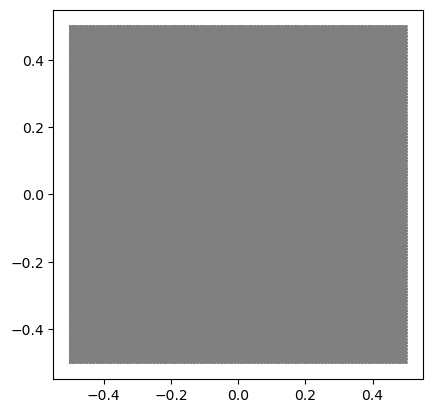

In [33]:
print("Mesh")
mesh = Mesh('mesh.xml')
hmin = mesh.hmin()
print('hmin',hmin)
print('Number of cells:',mesh.num_cells())
plot(mesh)
plt.show()

In [34]:
print("Material")
Gc =  Constant(2.7)
ell = Constant(2*hmin)
E = 210000.0
nu = 0.33
mu    = Constant(E / (2.0*(1.0 + nu)))
lmbda = Constant(E*nu / ((1.0 + nu)*(1.0 - 2.0*nu)))
kres_1 = Constant(1e-10)
eta = Constant(1.0E-3)

Material


In [35]:
print("Function Spaces")
# ---Displacement
V = VectorElement("Lagrange", mesh.ufl_cell(), 1)
V_u = FunctionSpace(mesh, V)
u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)
u.rename('u', 'u')

Function Spaces


In [36]:
print('Boundaries and Measures')
# ---Boundaries
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.5,1.E-8)
top = Top()
class Bot(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], -0.5,1.E-8)
bot = Bot()
# class Right(SubDomain):
#     def inside(self, x, on_boundary):
#         return near(x[0], 0.5,1.E-8)
# right = Right()
# class Left(SubDomain):
#     def inside(self, x, on_boundary):
#         return near(x[0], -0.5,1.E-8)
# left = Left()
# ---Measures
domains = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)
domains.set_all(0)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
# left.mark(boundaries, 1)
top.mark(boundaries, 2)
# right.mark(boundaries, 3)
bot.mark(boundaries, 4)
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
n = FacetNormal(mesh)
File('./PFAT1/boundaries.pvd') << boundaries 
File('./PFAT1/domains.pvd') << domains 

print("Boundary Conditions")
Uexp = Expression('t',t=0,degree=1)
bcu_t = DirichletBC(V_u.sub(1), Uexp, boundaries, 2) # top
bcu_b = DirichletBC(V_u, Constant((0.,0.)), boundaries, 4) # bot
bcu = [ bcu_t, bcu_b]
bca = []

Boundaries and Measures
Boundary Conditions


In [37]:
# ---Damage
V_alpha = FunctionSpace(mesh,'CG', 1)
alpha = Function(V_alpha)
dalpha = TrialFunction(V_alpha)
beta = TestFunction(V_alpha)
alpha.rename('damage', 'damage')
alpha_0 = Function(V_alpha)

alpha_lb = interpolate(Constant("0."), V_alpha)
alpha_ub = interpolate(Constant("1."), V_alpha)

print("Definitions")
def eps(u):
    return sym(grad(u))

# AT1 model (uncomment the following and comment the below function)
def w(alpha):
    """Dissipated energy function as a function of the damage """
    return alpha 

# AT2 model (uncomment the following and comment the above function)
# def w(alpha):
#     """Dissipated energy function as a function of the damage """
#     return alpha**2

def a(alpha,kres):
    
    """Stiffness modulation (degradation function) as a function of damage"""
    return (1 - alpha) ** 2. + kres

def sigma_0(u, E, nu):
    mu = Constant(E / (2. * (1. + nu)))
    lamb = Constant(E * nu / (1. - nu ** 2))
    return 2. * mu * (eps(u)) + lamb * tr(eps(u)) * Identity(len(u))

def sigma(u, alpha, E, nu, kres):
    return (a(alpha, kres)) * sigma_0(u, E, nu)
z = sympy.Symbol("z")
c_w = 4 * sympy.integrate(sympy.sqrt(w(z)), (z, 0, 1))
print('c_w:',c_w)

Definitions
c_w: 2


In [38]:
print("UFL forms")
elastic_energy = 0.5 * inner(sigma(u, alpha, E, nu, kres_1), eps(u))*dx(metadata={'quadrature_degree': 5}) 
dissipated_energy = Gc / float(c_w) * (w(alpha) / ell
                    + ell * dot(grad(alpha), grad(alpha))) * dx 
total_energy = elastic_energy + dissipated_energy #+ pressure_energy 
E_u = derivative(total_energy, u, v)
E_du = derivative(E_u,u,du)
E_da = derivative(total_energy, alpha, beta)
E_dda = derivative(E_da, alpha, dalpha)
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bcu)
solver_u = LinearVariationalSolver(problem_u)

UFL forms


In [39]:
print('loads')
loads = np.concatenate((np.linspace(0, 0.006, 6), np.linspace(0.006, 0.009, 300)[1:]))
print(loads[1:])
energies = np.zeros((len(loads), 4))
File_u = File(outputFolder + "/u.pvd")
File_d = File(outputFolder + "/d.pvd")

def postprocessing():
    File_u << (u, t)
    File_d << (alpha, t)
    elastic_energy_value = assemble(elastic_energy)
    surface_energy_value = assemble(dissipated_energy)
    # pressure_energy_value = assemble(pressure_energy)
    total_energy_value = assemble(total_energy)
    energies[i_t] = np.array([t, elastic_energy_value, surface_energy_value, \
                               total_energy_value])
    np.savetxt(outputFolder + '/energies.txt', energies)

loads
[0.0012     0.0024     0.0036     0.0048     0.006      0.00601003
 0.00602007 0.0060301  0.00604013 0.00605017 0.0060602  0.00607023
 0.00608027 0.0060903  0.00610033 0.00611037 0.0061204  0.00613043
 0.00614047 0.0061505  0.00616054 0.00617057 0.0061806  0.00619064
 0.00620067 0.0062107  0.00622074 0.00623077 0.0062408  0.00625084
 0.00626087 0.0062709  0.00628094 0.00629097 0.006301   0.00631104
 0.00632107 0.0063311  0.00634114 0.00635117 0.0063612  0.00637124
 0.00638127 0.0063913  0.00640134 0.00641137 0.0064214  0.00643144
 0.00644147 0.00645151 0.00646154 0.00647157 0.00648161 0.00649164
 0.00650167 0.00651171 0.00652174 0.00653177 0.00654181 0.00655184
 0.00656187 0.00657191 0.00658194 0.00659197 0.00660201 0.00661204
 0.00662207 0.00663211 0.00664214 0.00665217 0.00666221 0.00667224
 0.00668227 0.00669231 0.00670234 0.00671237 0.00672241 0.00673244
 0.00674247 0.00675251 0.00676254 0.00677258 0.00678261 0.00679264
 0.00680268 0.00681271 0.00682274 0.00683278 0.00684281 

In [40]:
alternate_conv_tol = 2.e-5
maxiter = 1000
for (i_t, t) in enumerate(loads[1:]):
    Uexp.t = t
    alternate_convergence = False
    alternate_iter = 0
    alpha_0.assign(alpha)
    while alternate_convergence is not True and alternate_iter < maxiter:
        alternate_iter += 1     
        solver_u.solve()
        problem_alpha = NonlinearVariationalProblem(E_da, alpha, bca, E_dda)
        solver_alpha  = NonlinearVariationalSolver(problem_alpha)
        problem_alpha.set_bounds(alpha_lb, alpha_ub)
        pra = solver_alpha.parameters
        pra['nonlinear_solver'] = 'snes'
        pra["snes_solver"]["method"] = "vinewtonrsls"
        pra["snes_solver"]["maximum_iterations"] = 300
        pra["snes_solver"]["absolute_tolerance"] = 1E-7
        pra["snes_solver"]["relative_tolerance"] = 1E-7
        pra["snes_solver"]["linear_solver"] = "mumps"
        pra["snes_solver"]["line_search"] = "basic"
        pra["snes_solver"]["report"] = True
        solver_alpha.solve()
        err_alpha = (alpha.vector() - alpha_0.vector()).norm('linf')
        if mpi_rank == 0:
            print(30 * '-' + " alternate_iter: {}".format(alternate_iter))
            print("Error: %2.8g" %(err_alpha))
        if err_alpha < alternate_conv_tol:
            alternate_convergence = True
        alpha_0.assign(alpha)
        
    alpha_lb.vector()[:]=alpha.vector()
    postprocessing()
    if mpi_rank == 0:
        print("\nEnd of timestep %d with load %g" % (i_t, t))

      Solving linear variational problem.
------------------------------ alternate_iter: 1
Error: 0.011704164
------------------------------ alternate_iter: 2
Error: 0.00020056181
      Solving nonlinear variational problem.
  0 SNES Function norm 2.167229997231e-03 
  1 SNES Function norm 3.280356616988e-18 
        PETSc SNES solver converged in 1 iterations with convergence reason CONVERGED_FNORM_ABS.
      Solving linear variational problem.
      Solving nonlinear variational problem.
  0 SNES Function norm 1.644968018983e-05 
  1 SNES Function norm 8.750470287095e-19 
        PETSc SNES solver converged in 1 iterations with convergence reason CONVERGED_FNORM_ABS.
      Solving linear variational problem.
      Solving nonlinear variational problem.
  0 SNES Function norm 3.039353225412e-07 
  1 SNES Function norm 8.676894244976e-19 
        PETSc SNES solver converged in 1 iterations with convergence reason CONVERGED_FNORM_ABS.
------------------------------ alternate_iter: 3
Err

Energy plots


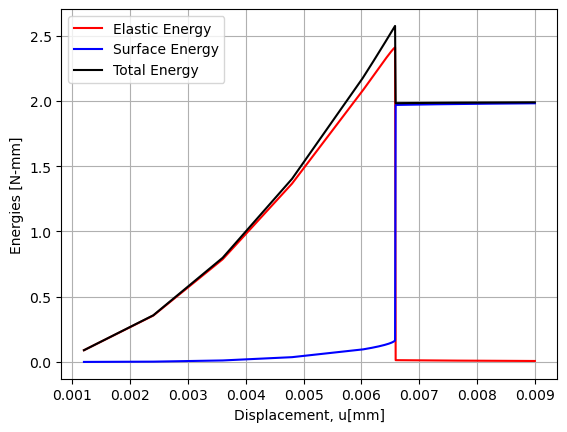

Everything is fine


In [54]:
print('Energy plots')
input_file = np.loadtxt('./PFH/energies.txt')
u = input_file[:,0]
elast_energy = input_file[:,1]
surf_energy = input_file[:,2]
tot_energy = input_file[:,3]
plt.plot(u,elast_energy,label='Elastic Energy',color='red')
plt.plot(u,surf_energy,label='Surface Energy',color='blue')
plt.plot(u,tot_energy,label='Total Energy',color='black')
plt.grid(True)
plt.legend()
plt.xlabel("Displacement, u[mm]")
plt.ylabel("Energies [N-mm]")
plt.show()